## The plan

I've been tasked with a challenge: to create an agent that can guide users in a mall to select a restaurant.
- Has search capabilities on text documents uploaded, like information about the meals and prices for each restaurant.
- no web search available

**Note** This will use the simplest stack possible to achieve the task, no fancy stuff.

We will be using the following libraries:
- fasthtml for the backend and frontend using daisyui
- chromadb for the vector store sqlite for database if needed
- lisette for the llm calls and chat management


1) develop the search functionality
2) develop the chat agent  
3) ui
4) monitoring functionality



In [ ]:

from fastcore.utils import *
from fasthtml.common import *
from fasthtml.jupyter import *
from fastlite import *
import fasthtml.components as fh
import httpx
import chromadb
import pandas as pd
import re
from lisette.core import Chat
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

## 0) EDA

In [ ]:
SHEET_ID = "13h-DvmpyZSa522PVam7rmqcbAXwuB3blSkKye4Wx6qc"

In [ ]:
url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=xlsx"
r = httpx.get(url, follow_redirects=True)
from io import BytesIO
sheets = pd.read_excel(BytesIO(r.content), sheet_name=None)
list(sheets.keys())

['restaurants',
 'cuisines_catalog',
 'restaurant_cuisines',
 'dish_keywords',
 'restaurant_dishes']

In [ ]:
for key, df in sheets.items():
    display(f"--{key}--")
    display(df.head())

'--restaurants--'

,id,name,website_url,phone,description_short,description_long,price_level,cuisines,dietary_tags,services,allow_reservations,opening_hours,menu_url,has_menu,updated_at
0,1,Andreu,https://www.thebicestercollection.com/la-roca-...,+34 93 842 35 49,"Family-run delicatessen with Iberian ham, sand...",Elegant delicatessen with signature products (...,medium,Catalan; Mediterranean; tapas; sandwiches,gluten_free; lactose_free; vegetarian,takeaway; bar,False,09:30-21:00,https://media.thebicestercollection.com/3z73vs...,True,2025-12-03 07:17:16.224
1,2,Atmósferas Mordisco,https://www.thebicestercollection.com/la-roca-...,+34 93 832 50 11,Tragaluz Group's garden restaurant: contempora...,It recaptures the spirit of the first Mordisco...,medium,Mediterranean; tapas; rice; meat; fish; vegeta...,vegetarian,takeaway; bar,False,09:30-21:00,https://media.thebicestercollection.com/3z73vs...,True,2025-12-03 07:17:16.224
2,3,Corso Iluzione,https://www.thebicestercollection.com/la-roca-...,+34 617 28 21 34,"Italian with a New York soul: modern pizzas, p...",Italian restaurant with Asian influences and a...,medium,Italian; pizza; pasta; fusion; burgers,halal; vegetarian,takeaway; bar,False,09:30-21:00,https://media.thebicestercollection.com/3z73vs...,True,2025-12-03 07:17:16.224
3,4,Centric,https://www.thebicestercollection.com/la-roca-...,+34 93 842 30 15,"Catalan and Mediterranean cuisine with tapas, ...","Local cuisine with tapas (octopus, croquettes,...",medium,Catalan; Mediterranean; tapas; rice; meat; fish,vegetarian,takeaway; bar,False,09:30-21:00,https://media.thebicestercollection.com/3z73vs...,True,2025-12-03 07:17:16.224
4,5,Dino,https://www.thebicestercollection.com/la-roca-...,+34 938 42 30 15,"Italian ice cream shop with vegan sorbets, lac...",Italian ice cream tradition with classic and s...,low,ice cream shop,vegan; lactose_free,takeaway,False,09:30-21:00,https://www.thebicestercollection.com/la-roca-...,False,2025-12-03 07:17:16.224


'--cuisines_catalog--'

,id,name,synonyms,updated_at
0,1,Catalan,"[""catalan"",""catalan cuisine"",""catalan food""]",2025-12-03 07:17:16.224
1,2,Mediterranean,"[""mediterranean"",""mediterranean cuisine"",""medi...",2025-12-03 07:17:16.224
2,3,Italian,"[""italian"",""italian cuisine"",""italian food""]",2025-12-03 07:17:16.224
3,4,American,"[""american"",""american cuisine"",""american food""...",2025-12-03 07:17:16.224
4,5,Japanese,"[""japanese"",""japanese cuisine"",""japanese food""...",2025-12-03 07:17:16.224


'--restaurant_cuisines--'

,restaurant_id,cuisine_id,weight,updated_at
0,1,1,80,2025-12-03 07:17:16.224
1,1,2,70,2025-12-03 07:17:16.224
2,1,6,60,2025-12-03 07:17:16.224
3,1,7,50,2025-12-03 07:17:16.224
4,1,8,50,2025-12-03 07:17:16.224


'--dish_keywords--'

,id,text,synonyms,category,dietary_tags,language,updated_at
0,1,Olive tasting of three varieties: spicy,NaN,appetizers and preserves specialties,NaN,en,2025-12-03 07:17:16.224
1,2,Greek and mediterranean,NaN,appetizers and preserves specialties,gluten-free; lactose-free,en,2025-12-03 07:17:16.224
2,3,Spiced house olives,NaN,appetizers and preserves specialties,gluten-free; lactose-free,en,2025-12-03 07:17:16.224
3,4,Classic greek olives,NaN,appetizers and preserves specialties,gluten-free; lactose-free,en,2025-12-03 07:17:16.224
4,5,Gordal olives with a mediterranean touch,NaN,appetizers and preserves specialties,gluten-free; lactose-free,en,2025-12-03 07:17:16.224


'--restaurant_dishes--'

,restaurant_id,dish_id,weight,updated_at,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,1,1,10,2025-12-03 07:17:16.224,NaN,NaN,NaN,NaN,NaN
1,1,2,10,2025-12-03 07:17:16.224,NaN,NaN,NaN,NaN,NaN
2,1,3,95,2025-12-03 07:17:16.224,NaN,NaN,NaN,NaN,NaN
3,1,4,95,2025-12-03 07:17:16.224,NaN,NaN,NaN,NaN,NaN
4,1,5,95,2025-12-03 07:17:16.224,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_restaurants = sheets['restaurants']
df_restaurants.sample().T

,2
id,3
name,Corso Iluzione
website_url,https://www.thebicestercollection.com/la-roca-...
phone,+34 617 28 21 34
description_short,"Italian with a New York soul: modern pizzas, p..."
description_long,Italian restaurant with Asian influences and a...
price_level,medium
cuisines,Italian; pizza; pasta; fusion; burgers
dietary_tags,halal; vegetarian
services,takeaway; bar


In [ ]:
df_restaurants.loc[0,'menu_url']

'https://media.thebicestercollection.com/3z73vs69pqez/2KxrFawoNvrJito1aTssL8/943ecebc1d22793f7b5918e53e265813/carta_Andreu_La_Roca_ENG.pdf'

In [ ]:
df_restaurants.shape

(16, 15)

In [ ]:
df_restaurants['services'].value_counts()

services
takeaway; bar    10
takeaway          6
Name: count, dtype: int64

### Restaurant description

In [ ]:
def make_restaurant_doc(row):
    """Create a searchable description for a restaurant."""
    parts = [
        f"{row['name']} is a {row['price_level']}-priced restaurant.",
        row['description_long'] or row['description_short'],
        f"Cuisine types: {row['cuisines']}." if pd.notna(row['cuisines']) else "",
        f"Dietary options: {row['dietary_tags']}." if pd.notna(row['dietary_tags']) else "",
        f"Services: {row['services']}." if pd.notna(row['services']) else "",
        f"Open {row['opening_hours']}." if pd.notna(row['opening_hours']) else "",
    ]
    return " ".join(p for p in parts if p)

In [ ]:
make_restaurant_doc(df_restaurants.iloc[0])

'Andreu is a medium-priced restaurant. Elegant delicatessen with signature products (Iberian ham, smoked salmon, artisan bread, and olives). A wide selection of appetizers, sandwiches, sharing dishes, and desserts; the menu includes several gluten-free and lactose-free options. Ideal for a light meal or on the go. Cuisine types: Catalan; Mediterranean; tapas; sandwiches. Dietary options: gluten_free; lactose_free; vegetarian. Services: takeaway; bar. Open 09:30-21:00.'

### Dishes description

Most of the values are updated this month (tomorrow actually)

In [ ]:
cols = ['restaurant_id', 'dish_id', 'weight', 'updated_at']
df_rest_dishes = sheets['restaurant_dishes'][cols]
df_rest_dishes['updated_at'].dt.date.value_counts().head()

updated_at
2025-12-03    592
2025-11-21      4
2025-11-23      3
2025-11-22      3
2025-11-24      3
Name: count, dtype: int64

Dishes ids are not duplicated:

In [ ]:
df_rest_dishes.groupby(['restaurant_id', 'dish_id']).size().value_counts()

1    697
Name: count, dtype: int64

And weights are not normalized, but we dont actually need norm, just the order.

In [ ]:
df_rest_dishes.groupby('restaurant_id')['weight'].sum()

restaurant_id
1     3480
2     2095
3     5240
4     2520
5       95
6     5115
7     2810
8     2285
9     2195
10     480
12    2145
14    1775
15    2390
16    1770
Name: weight, dtype: int64

In [ ]:
df_dishes = df_rest_dishes.merge(
    sheets['dish_keywords'], 
    left_on='dish_id', 
    right_on='id',
    suffixes=('', '_dish')
).merge(
    sheets['restaurants'][['id', 'name']], 
    left_on='restaurant_id', 
    right_on='id',
    suffixes=('', '_rest')
)

# Sort by restaurant and weight (descending)
df_dishes = df_dishes.sort_values(['restaurant_id', 'weight'], ascending=[True, False])
df_dishes.sample(2).T

,455,168
restaurant_id,7,3
dish_id,456,169
weight,10,10
updated_at,2025-12-03 07:17:16.224000,2025-12-03 07:17:16.224000
id,456,169
text,Potato chips with smoked mayonnaise,Truffle parmesan chips (contains dairy)
synonyms,NaN,NaN
category,kids,appetizers
dietary_tags,NaN,NaN
language,en,en


Help me create a dish description based on the data we have above.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Looking at your data structure, I can help you create a function to generate dish descriptions. Based on the data available, each dish has text, category, dietary tags, and is associated with a restaurant.

Here's a function to create searchable dish descriptions:

```python
def make_dish_doc(row):
    """Create a searchable description for a dish."""
    parts = [
        f"{row['text']}",
        f"from {row['name']}.",
        f"Category: {row['category']}." if pd.notna(row['category']) else "",
        f"Dietary: {row['dietary_tags']}." if pd.notna(row['dietary_tags']) else "",
    ]
    return " ".join(p for p in parts if p)
```

Let me test it with a sample:

```python
make_dish_doc(df_dishes.iloc[0])
```

This creates a concise description that includes:
- The dish name/description (from `text` field)
- The restaurant it's from
- The category (e.g., appetizers, kids, desserts)
- Any dietary tags if available

You could also create a more detailed version that includes the weight (popularity/importance score):

```python
def make_dish_doc_detailed(row):
    """Create a detailed searchable description for a dish."""
    parts = [
        f"{row['text']} (priority: {row['weight']})",
        f"available at {row['name']}.",
        f"This is a {row['category']} item." if pd.notna(row['category']) else "",
        f"Suitable for: {row['dietary_tags']}." if pd.notna(row['dietary_tags']) else "",
    ]
    return " ".join(p for p in parts if p)
```

Which approach would you prefer - the simpler version or the more detailed one with weights included?

Yes, i want to augment the restaurant with the top dishes but also want to answer if there is something gluten free at restaurant xxx

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! So you want a two-pronged approach:

1. **Augment restaurant descriptions** with their top dishes (using the weight field)
2. **Create separate dish documents** so users can search for specific dietary needs at specific restaurants

Here's what I suggest:

```python
def make_restaurant_doc_with_dishes(restaurant_row, top_n=5):
    """Create restaurant description augmented with top dishes."""
    # Base restaurant info
    parts = [
        f"{restaurant_row['name']} is a {restaurant_row['price_level']}-priced restaurant.",
        restaurant_row['description_long'] or restaurant_row['description_short'],
        f"Cuisine types: {restaurant_row['cuisines']}." if pd.notna(restaurant_row['cuisines']) else "",
        f"Dietary options: {restaurant_row['dietary_tags']}." if pd.notna(restaurant_row['dietary_tags']) else "",
        f"Services: {restaurant_row['services']}." if pd.notna(restaurant_row['services']) else "",
        f"Open {restaurant_row['opening_hours']}." if pd.notna(restaurant_row['opening_hours']) else "",
    ]
    
    # Get top dishes for this restaurant
    rest_dishes = df_dishes[df_dishes['restaurant_id'] == restaurant_row['id']].head(top_n)
    if len(rest_dishes) > 0:
        dish_list = "; ".join(rest_dishes['text'].tolist())
        parts.append(f"Popular dishes: {dish_list}.")
    
    return " ".join(p for p in parts if p)
```

```python
def make_dish_doc(row):
    """Create searchable dish document with restaurant context."""
    parts = [
        f"{row['text']}",
        f"at {row['name']}.",
        f"Category: {row['category']}." if pd.notna(row['category']) else "",
        f"Dietary: {row['dietary_tags']}." if pd.notna(row['dietary_tags']) else "",
    ]
    return " ".join(p for p in parts if p)
```

This way:
- **Restaurant docs** give overview + top dishes → answers "what restaurants serve Italian food?"
- **Dish docs** with dietary tags → answers "what gluten-free options does Andreu have?"

Want me to test these functions with your data to see how they look?

In [ ]:
def make_restaurant_doc_with_dishes(row, top_n=10):
    """Create a searchable description for a restaurant with top dishes."""
    # Base restaurant info
    parts = [
        f"{row['name']} is a {row['price_level']}-priced restaurant.",
        row['description_long'] or row['description_short'],
        f"Cuisine types: {row['cuisines']}." if pd.notna(row['cuisines']) else "",
        f"Dietary options available: {row['dietary_tags']}." if pd.notna(row['dietary_tags']) else "",
        f"Services: {row['services']}." if pd.notna(row['services']) else "",
        f"Open {row['opening_hours']}." if pd.notna(row['opening_hours']) else "",
    ]
    
    # Get top dishes for this restaurant
    rest_dishes = df_dishes[df_dishes['restaurant_id'] == row['id']].head(top_n)
    
    if len(rest_dishes) > 0:
        parts.append("\nMenu highlights:")
        for _, dish in rest_dishes.iterrows():
            dish_text = dish['text']
            # Add dietary tags to each dish if available
            if pd.notna(dish['dietary_tags']):
                dish_text += f" ({dish['dietary_tags']})"
            parts.append(f"- {dish_text}")
    
    return " ".join(p for p in parts if p)

In [ ]:
doc = make_restaurant_doc_with_dishes(df_restaurants.iloc[0])
print(doc)

Andreu is a medium-priced restaurant. Elegant delicatessen with signature products (Iberian ham, smoked salmon, artisan bread, and olives). A wide selection of appetizers, sandwiches, sharing dishes, and desserts; the menu includes several gluten-free and lactose-free options. Ideal for a light meal or on the go. Cuisine types: Catalan; Mediterranean; tapas; sandwiches. Dietary options available: gluten_free; lactose_free; vegetarian. Services: takeaway; bar. Open 09:30-21:00. 
Menu highlights: - Spiced house olives (gluten-free; lactose-free) - Classic greek olives (gluten-free; lactose-free) - Gordal olives with a mediterranean touch (gluten-free; lactose-free) - Toasted bread with tomato and slices of pernil andreu - Baguette with andreu pernil cheese - Croquettes with the characteristic flavor of pernil andreu - Baguette with andreu pernil cheese - Pernil andreu with melted cheese on brioche bread - Our pernil served with coca bread and tomato (lactose-free) - Charcuterie board


In [ ]:

doc = make_restaurant_doc_with_dishes(df_restaurants.iloc[6])
print(doc)


Mori by Parco is a high-priced restaurant. Exclusive experience at La Roca Village: starters, salads, a variety of sushi and sashimi, maki, tempura, yakisoba, and skewers; a selection of Japanese desserts and ice cream. Cuisine types: Japanese; sushi. Dietary options available: vegetarian. Services: takeaway; bar. Open 09:30-21:00. 
Menu highlights: - Sushi sho (12 nigiris) - Sushi bai (6 nigiris) - Sushi sake (9 salmon nigiris) - Sashimi sake (9 salmon sashimi) - Sashimi ciku (13 sashimi) - Sashimi 4/4 - Sushi by the piece (salmon, tuna, eel, shrimp) - Tomaki - Truffle uramaki - Spicy sake maki


### Zone tags

In [ ]:
df_restaurants['name']

0                    Andreu
1       Atmósferas Mordisco
2            Corso Iluzione
3                   Centric
4                      Dino
5               Farggi 1957
6             Mori by Parco
7                 Starbucks
8           Waff (Ice Pops)
9                     Lindt
10           Ralph's Coffee
11             Fire & Bread
12    Gourmet La Vanguardia
13                    Gasso
14             Izky Noodles
15              Rocambolesc
Name: name, dtype: object

We dont have the location of the restaurant in the dataset. Lets add them by hand.

Some locals were not found. And based on the map I use near locals instead:

- WAFF -> PDPAOLA
- Rocambolesc -> Helly Hansen

In [ ]:
def extract_coords_from_gmaps_url(url):
    """Extract latitude and longitude from a Google Maps URL."""
    # Pattern 1: !3d and !4d format (the actual place coordinates)
    lat_match = re.search(r'!3d(-?\d+\.\d+)', url)
    lng_match = re.search(r'!4d(-?\d+\.\d+)', url)
    if lat_match and lng_match:
        return float(lat_match.group(1)), float(lng_match.group(1))
    
    # Pattern 2: @lat,lng,zoom format (fallback, map view coordinates)
    match = re.search(r'@(-?\d+\.\d+),(-?\d+\.\d+)', url)
    if match:
        return float(match.group(1)), float(match.group(2))
    
    return None, None

In [ ]:
urls = {
    'Andreu': 'https://www.google.com/maps/place/Andreu+Xarcuteria+i+Tastets+(La+Roca+Village)/@41.6112276,2.3440647,17.73z/data=!4m6!3m5!1s0x12a4c80b38fb1597:0x97c53325a2e8c12a!8m2!3d41.6133617!4d2.345123!16s%2Fg%2F1tdrzc91?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Atmósferas Mordisco': 'https://www.google.com/maps/place/Atmósferas+Mordisco/@41.6112276,2.3440647,17.73z/data=!4m6!3m5!1s0x12a4c91c2c58eff7:0x5425a56be6342c8b!8m2!3d41.6107384!4d2.3438229!16s%2Fg%2F11hy_xs2mh?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Corso Iluzione': 'https://www.google.com/maps/place/Corso+Iluzione/@41.6083886,2.3395416,17z/data=!3m1!4b1!4m6!3m5!1s0x12a4c9e4a002ea03:0x7a5582e638a45bb7!8m2!3d41.6083886!4d2.3421165!16s%2Fg%2F11rxqd9mcc?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Centric': 'https://www.google.com/maps/place/C%C3%A8ntric+Restaurant+%26+Caf%C3%A8/@41.6108415,2.3406045,17.87z/data=!4m10!1m2!2m1!1sCentric!3m6!1s0x12a4c99bf4957955:0x88e88a0888300524!8m2!3d41.6116881!4d2.3443858!15sCgdDZW50cmljWgkiB2NlbnRyaWOSAQpyZXN0YXVyYW50mgEkQ2hkRFNVaE5NRzluUzBWSlEwRm5UVVIzZFRoUE56Rm5SUkFC4AEA-gEECAAQOQ!16s%2Fg%2F11wg3tc2qs?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Dino': 'https://www.google.com/maps/place/Don+Dino/@41.6161217,2.3442356,17.5z/data=!4m6!3m5!1s0x12a4c9aa1a29bca3:0xc65bfa252fa3de1b!8m2!3d41.6163158!4d2.3463198!16s%2Fg%2F11bzzz5t80?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Farggi 1957': 'https://www.google.com/maps/place/Farggi+La+Roca+Village/@41.6007267,2.3306299,14.98z/data=!4m10!1m2!2m1!1sFarggi+1957+la+roca!3m6!1s0x12a4c91caeafa947:0x2c62baa539cfba!8m2!3d41.608412!4d2.3425552!15sChNGYXJnZ2kgMTk1NyBsYSByb2NhWhUiE2ZhcmdnaSAxOTU3IGxhIHJvY2GSAQ5pY2VfY3JlYW1fc2hvcJoBI0NoWkRTVWhOTUc5blMwVkpRMEZuU1VOd2RIRnFiMVJSRUFF4AEA-gEECAAQNA!16s%2Fg%2F11p5_7cvjy?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Mori by Parco': 'https://www.google.com/maps/place/Mori+much+more/@41.6122125,2.3424865,17z/data=!3m1!4b1!4m6!3m5!1s0x12a4c9acf6d7c19b:0xc907defd9e2dd514!8m2!3d41.6122125!4d2.3450614!16s%2Fg%2F11dyqnnszh?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Starbucks': 'https://www.google.com/maps/place/Starbucks/@41.6102456,2.3330624,15.63z/data=!4m10!1m2!2m1!1sStarbucks!3m6!1s0x12a4c823b1eab02d:0x66513144ada5da2e!8m2!3d41.6102164!4d2.3432526!15sCglTdGFyYnVja3MiA4gBAVoLIglzdGFyYnVja3OSAQRjYWZl4AEA!16s%2Fg%2F11xw99hwk?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Waff (Ice Pops)': 'https://www.google.com/maps/place/PDPAOLA/@41.6094678,2.3415329,18z/data=!3m1!4b1!4m6!3m5!1s0x12a4c92863b5adc7:0x3848151a9204a750!8m2!3d41.6094678!4d2.3428204!16s%2Fg%2F11v00dnbgg?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Lindt': 'https://www.google.com/maps/place/Lindt/@41.6076008,2.3472311,15.54z/data=!4m10!1m2!2m1!1sLindt!3m6!1s0x12a4c95603b5ed4b:0x74c60a69456bb3e4!8m2!3d41.6108584!4d2.3441826!15sCgVMaW5kdCIDiAEBWgciBWxpbmR0kgEOY2hvY29sYXRlX3Nob3DgAQA!16s%2Fg%2F11rsv4hmjj?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Fire & Bread': 'https://www.google.com/maps/place/Fire+%26+Bread/@41.6104167,2.3422907,18z/data=!3m1!4b1!4m6!3m5!1s0x12a4c9ace7d3506d:0x96a6fc26dd7acb5e!8m2!3d41.6104167!4d2.343262!16s%2Fg%2F11hbfjq__5?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Gasso': 'https://www.google.com/maps/place/Gass%C3%B3+Artesans/@41.6087512,2.3397058,17z/data=!3m1!4b1!4m6!3m5!1s0x12a4c90003f47919:0x7a0af53f92502525!8m2!3d41.6087512!4d2.3422807!16s%2Fg%2F11zkmxzzzv?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Izky Noodles': 'https://www.google.com/maps/place/Izky/@41.6094216,2.3402081,17z/data=!3m1!4b1!4m6!3m5!1s0x12a4c9ad242533ef:0x64de704a51f19b04!8m2!3d41.6094216!4d2.342783!16s%2Fg%2F11h5vyg7nz?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D',
    'Rocambolesc': 'https://www.google.com/maps/place/Helly+Hansen/@41.6118815,2.3420831,17z/data=!3m1!4b1!4m6!3m5!1s0x12a4c95684a2ac07:0xc6ade012764769ef!8m2!3d41.6118815!4d2.344658!16s%2Fg%2F11rkj1_glb?entry=ttu&g_ep=EgoyMDI1MTEyMy4xIKXMDSoASAFQAw%3D%3D'
}

coords = {}
for name, url in urls.items():
    lat, lng = extract_coords_from_gmaps_url(url)
    coords[name] = {'lat': lat, 'lng': lng}
    print(f"{name}: {lat}, {lng}")

Andreu: 41.6133617, 2.345123
Atmósferas Mordisco: 41.6107384, 2.3438229
Corso Iluzione: 41.6083886, 2.3421165
Centric: 41.6116881, 2.3443858
Dino: 41.6163158, 2.3463198
Farggi 1957: 41.608412, 2.3425552
Mori by Parco: 41.6122125, 2.3450614
Starbucks: 41.6102164, 2.3432526
Waff (Ice Pops): 41.6094678, 2.3428204
Lindt: 41.6108584, 2.3441826
Fire & Bread: 41.6104167, 2.343262
Gasso: 41.6087512, 2.3422807
Izky Noodles: 41.6094216, 2.342783
Rocambolesc: 41.6118815, 2.344658


In [ ]:
# Centric is at: 41.6116881, 2.3443858
# Let's place Dino very close to it
coords['Dino'] = {'lat': 41.6117, 'lng': 2.3444}

Centroid: 41.610537, 2.343622


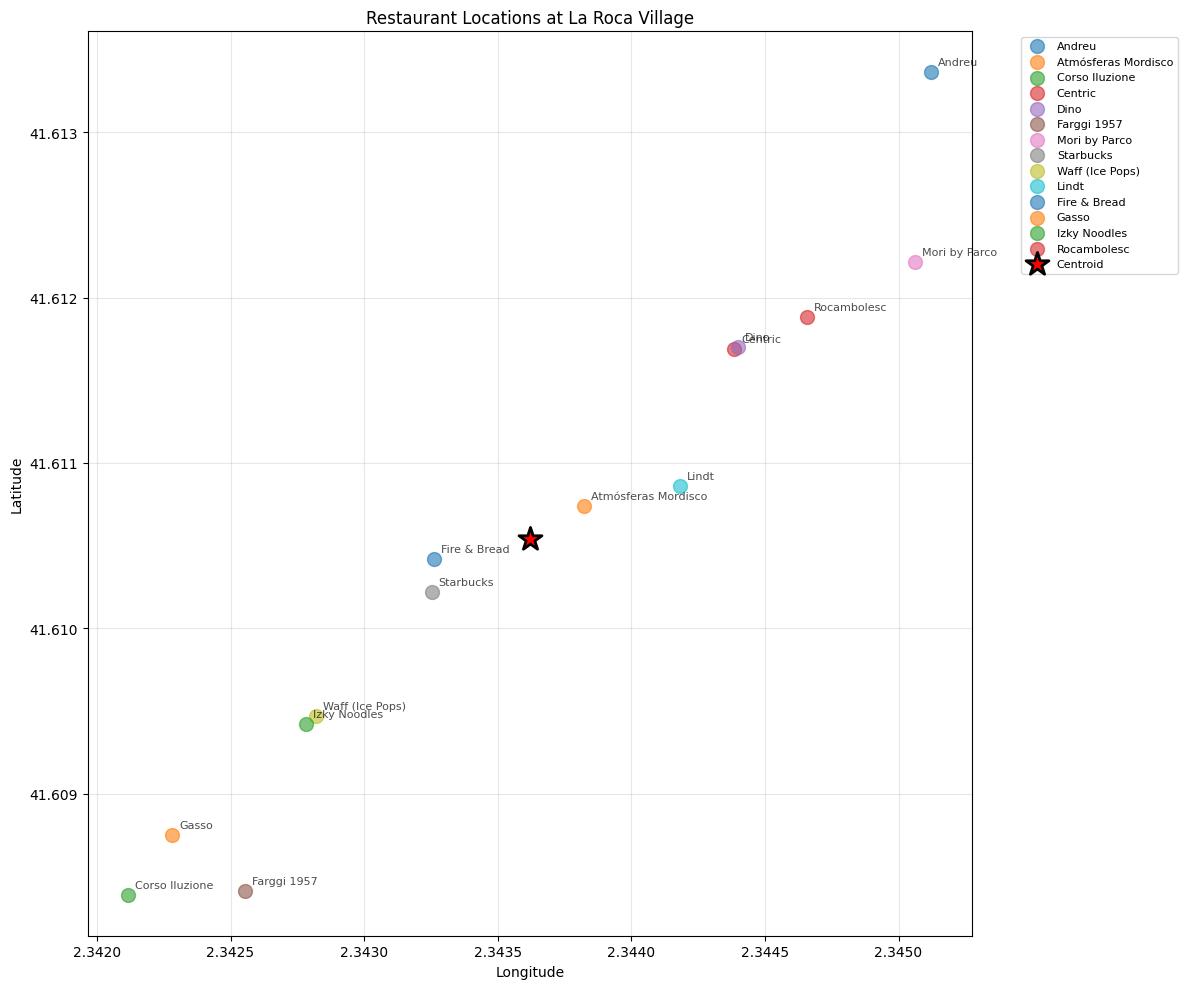


Centroid coordinates: 41.610537, 2.343622


In [ ]:
# Calculate centroid
lats = [c['lat'] for c in coords.values()]
lngs = [c['lng'] for c in coords.values()]

centroid_lat = sum(lats) / len(lats)
centroid_lng = sum(lngs) / len(lngs)

print(f"Centroid: {centroid_lat:.6f}, {centroid_lng:.6f}")

# Create a simple scatter plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot restaurants
for name, coord in coords.items():
    ax.scatter(coord['lng'], coord['lat'], s=100, alpha=0.6, label=name)
    ax.annotate(name, (coord['lng'], coord['lat']), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.7)

# Plot centroid
ax.scatter(centroid_lng, centroid_lat, s=300, c='red', marker='*', 
           label='Centroid', zorder=5, edgecolors='black', linewidths=2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Restaurant Locations at La Roca Village')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

print(f"\nCentroid coordinates: {centroid_lat:.6f}, {centroid_lng:.6f}")

In [ ]:
def classify_zone(lat, centroid=centroid_lat, threshold=0.0011):
    """Classify restaurant into north/center/south zones."""
    if lat > centroid + threshold:
        return 'north'
    elif lat < centroid - threshold:
        return 'south'
    else:
        return 'center'

# Apply to each restaurant
zones = {}
for name, coord in coords.items():
    zone = classify_zone(coord['lat'])
    zones[name] = zone
    print(f"{name}: {zone} (lat: {coord['lat']:.6f})")

Andreu: north (lat: 41.613362)
Atmósferas Mordisco: center (lat: 41.610738)
Corso Iluzione: south (lat: 41.608389)
Centric: north (lat: 41.611688)
Dino: north (lat: 41.611700)
Farggi 1957: south (lat: 41.608412)
Mori by Parco: north (lat: 41.612212)
Starbucks: center (lat: 41.610216)
Waff (Ice Pops): center (lat: 41.609468)
Lindt: center (lat: 41.610858)
Fire & Bread: center (lat: 41.610417)
Gasso: south (lat: 41.608751)
Izky Noodles: south (lat: 41.609422)
Rocambolesc: north (lat: 41.611882)


In [ ]:

name_to_zone = {name: zone for name, zone in zones.items()}
df_restaurants['zone'] = df_restaurants['name'].map(name_to_zone)
df_restaurants['lat'] = df_restaurants['name'].map(lambda n: coords.get(n, {}).get('lat'))
df_restaurants['lng'] = df_restaurants['name'].map(lambda n: coords.get(n, {}).get('lng'))

df_restaurants[['name', 'zone', 'lat', 'lng']].head()


,name,zone,lat,lng
0,Andreu,north,41.613362,2.345123
1,Atmósferas Mordisco,center,41.610738,2.343823
2,Corso Iluzione,south,41.608389,2.342116
3,Centric,north,41.611688,2.344386
4,Dino,north,41.611700,2.344400


In [ ]:
df_restaurants['zone'].value_counts()

zone
north     5
center    5
south     4
Name: count, dtype: int64

Lets update our description to include the tags:

In [ ]:
def make_restaurant_doc_with_dishes(row, top_n=10):
    """Create a searchable description for a restaurant with top dishes."""
    # Base restaurant info
    parts = [
        f"{row['name']} is a {row['price_level']}-priced restaurant",
        f"located in the {row['zone']} zone of the mall." if pd.notna(row['zone']) else ".",
        row['description_long'] or row['description_short'],
        f"Cuisine types: {row['cuisines']}." if pd.notna(row['cuisines']) else "",
        f"Dietary options available: {row['dietary_tags']}." if pd.notna(row['dietary_tags']) else "",
        f"Services: {row['services']}." if pd.notna(row['services']) else "",
        f"Open {row['opening_hours']}." if pd.notna(row['opening_hours']) else "",
    ]
    
    # Get top dishes for this restaurant
    rest_dishes = df_dishes[df_dishes['restaurant_id'] == row['id']].head(top_n)
    
    if len(rest_dishes) > 0:
        parts.append("\nMenu highlights:")
        for _, dish in rest_dishes.iterrows():
            dish_text = dish['text']
            # Add dietary tags to each dish if available
            if pd.notna(dish['dietary_tags']):
                dish_text += f" ({dish['dietary_tags']})"
            parts.append(f"- {dish_text}")
    
    return " ".join(p for p in parts if p)

In [ ]:
doc = make_restaurant_doc_with_dishes(df_restaurants.iloc[0])
print(doc)

Andreu is a medium-priced restaurant located in the north zone of the mall. Elegant delicatessen with signature products (Iberian ham, smoked salmon, artisan bread, and olives). A wide selection of appetizers, sandwiches, sharing dishes, and desserts; the menu includes several gluten-free and lactose-free options. Ideal for a light meal or on the go. Cuisine types: Catalan; Mediterranean; tapas; sandwiches. Dietary options available: gluten_free; lactose_free; vegetarian. Services: takeaway; bar. Open 09:30-21:00. 
Menu highlights: - Spiced house olives (gluten-free; lactose-free) - Classic greek olives (gluten-free; lactose-free) - Gordal olives with a mediterranean touch (gluten-free; lactose-free) - Toasted bread with tomato and slices of pernil andreu - Baguette with andreu pernil cheese - Croquettes with the characteristic flavor of pernil andreu - Baguette with andreu pernil cheese - Pernil andreu with melted cheese on brioche bread - Our pernil served with coca bread and tomato 

In [ ]:
doc = make_restaurant_doc_with_dishes(df_restaurants.iloc[7])
print(doc)

Starbucks is a low-priced restaurant located in the center zone of the mall. A wide selection of coffees and drinks, pastries, muffins, cakes, and sandwiches; salad options, snacks, and bottled drinks. A comfortable setting for a break while shopping. Cuisine types: cafeteria; light meal. Dietary options available: vegetarian. Services: takeaway. Open 09:30-21:00. 
Menu highlights: - Lemon cake - Orange and chocolate cake - Butter croissant - Croissant multicereal - Chocolate muffin - Blueberry muffin - Vanilla muffin - Gluten-free muffins - Cookie nutella - Cookie chocolate


## 1) Vector store

In [ ]:
client = chromadb.PersistentClient(path="chromadb")
# client.delete_collection(name="restaurants")
collection = client.get_or_create_collection(name="restaurants")

In [ ]:
def make_metadata(row):
    # Parse opening hours
    opening_time = ""
    closing_time = ""
    if pd.notna(row['opening_hours']) and '-' in str(row['opening_hours']):
        times = str(row['opening_hours']).split('-')
        opening_time = times[0].strip()
        closing_time = times[1].strip()
    
    return {
        "restaurant_id": int(row['id']),
        "name": row['name'],
        "price_level": row['price_level'],
        "zone": row['zone'] if pd.notna(row['zone']) else "",
        "latitude": float(row['lat']) if pd.notna(row['lat']) else 0.0,
        "longitude": float(row['lng']) if pd.notna(row['lng']) else 0.0,
        "has_vegetarian": "vegetarian" in str(row['dietary_tags']),
        "has_vegan": "vegan" in str(row['dietary_tags']),
        "has_gluten_free": "gluten_free" in str(row['dietary_tags']),
        "has_menu": bool(row['has_menu']),
        "allow_reservations": bool(row['allow_reservations']),
        "has_takeaway": "takeaway" in str(row['services']),
        "has_bar": "bar" in str(row['services']),
        "phone": row['phone'],
        "website_url": row['website_url'],
        "opening_time": opening_time,
        "closing_time": closing_time,
    }

In [ ]:
row = df_restaurants.iloc[2]
metadata = make_metadata(row)
document = make_restaurant_doc_with_dishes(row)
metadata, document

({'restaurant_id': 3,
  'name': 'Corso Iluzione',
  'price_level': 'medium',
  'zone': 'south',
  'latitude': 41.6083886,
  'longitude': 2.3421165,
  'has_vegetarian': True,
  'has_vegan': False,
  'has_gluten_free': False,
  'has_menu': True,
  'allow_reservations': False,
  'has_takeaway': True,
  'has_bar': True,
  'phone': '+34 617 28 21 34',
  'website_url': 'https://www.thebicestercollection.com/la-roca-village/es/donde-comer/iluzione/',
  'opening_time': '09:30',
  'closing_time': '21:00'},
 "Corso Iluzione is a medium-priced restaurant located in the south zone of the mall. Italian restaurant with Asian influences and a designer atmosphere. Appetizers, salads, pokes, pasta (gnocchi in pizza bowls, carbonara, ragù), modern pizzas, burgers (halal options), main courses, and desserts. Bar menu and spritzes. Cuisine types: Italian; pizza; pasta; fusion; burgers. Dietary options available: halal; vegetarian. Services: takeaway; bar. Open 09:30-21:00. \nMenu highlights: - Fettuccine 

In [ ]:
documents = []
metadatas = []
ids = []

for idx, row in df_restaurants.iterrows():
    documents.append(make_restaurant_doc_with_dishes(row))
    metadatas.append(make_metadata(row))
    ids.append(f"rest_{row['id']}")

# collection.add(documents=documents, metadatas=metadatas, ids=ids)
collection.upsert(documents=documents, metadatas=metadatas, ids=ids)


In [ ]:
results = collection.query(
    query_texts=["I want Italian food in south zone"],
    n_results=2
)

results

{'ids': [['rest_3', 'rest_4']],
 'embeddings': None,
 'documents': [["Corso Iluzione is a medium-priced restaurant located in the south zone of the mall. Italian restaurant with Asian influences and a designer atmosphere. Appetizers, salads, pokes, pasta (gnocchi in pizza bowls, carbonara, ragù), modern pizzas, burgers (halal options), main courses, and desserts. Bar menu and spritzes. Cuisine types: Italian; pizza; pasta; fusion; burgers. Dietary options available: halal; vegetarian. Services: takeaway; bar. Open 09:30-21:00. \nMenu highlights: - Fettuccine with ragÃ¹ served with parmesan cheese (contains dairy; contains gluten; contains egg) - Tagliatelle s carbonara with egg, bacon and ricotta (contains dairy; contains gluten; contains egg) - Lasagna (contains dairy; contains gluten; contains egg) - Chef's whimsical ravioli (contains gluten; contains egg) - Pasta with shrimp, octopus and squid reduction (contains dairy; contains gluten; contains crustaceans; contains fish; contains 

In [ ]:
results = collection.query(
    query_texts=["cheap lunch"],
    where={"price_level": "low"},  # filter on metadata
    n_results=2
)
results

{'ids': [['rest_9', 'rest_15']],
 'embeddings': None,
 'documents': [['Starbucks is a low-priced restaurant located in the center zone of the mall. A wide selection of coffees and drinks, pastries, muffins, cakes, and sandwiches; salad options, snacks, and bottled drinks. A comfortable setting for a break while shopping. Cuisine types: cafeteria; light meal. Dietary options available: vegetarian. Services: takeaway. Open 09:30-21:00. \nMenu highlights: - Lemon cake - Orange and chocolate cake - Butter croissant - Croissant multicereal - Chocolate muffin - Blueberry muffin - Vanilla muffin - Gluten-free muffins - Cookie nutella - Cookie chocolate',
   "Ralph's Coffee is a low-priced restaurant . A cozy and convenient spot for a break during your shopping day. Cuisine types: cafeteria; light meal. Dietary options available: halal; vegetarian. Services: takeaway; bar. Open 09:30-21:00. \nMenu highlights: - espresso coffee - Cappuccino - Latté - American - Flat White - Iced Latte - Mocha (

In [ ]:
results = collection.query(
    query_texts=["Me gustaría comer algo vegetariano"],
    n_results=2
)

results

{'ids': [['rest_4', 'rest_11']],
 'embeddings': None,
 'documents': [['Centric is a medium-priced restaurant located in the north zone of the mall. Local cuisine with tapas (octopus, croquettes, bravas), salads, meat and fish dishes, rice dishes, and pasta. Classic desserts and a wine list. Relaxed atmosphere, all-day dining. Cuisine types: Catalan; Mediterranean; tapas; rice; meat; fish. Dietary options available: vegetarian. Services: takeaway; bar. Open 09:30-21:00. \nMenu highlights: - CalÃ§ots tempura - Fried anchovies - Grilled shrimp - Anchovies with coca bread - Grilled octopus with potatoes - Iberian ham - Coca bread with tomato - Patatas bravas - Broken egg with ham - Iberian ham croquettes',
   'Gourmet La Vanguardia is a medium-priced restaurant . The menu includes all-day dining options such as tapas, rice dishes, and seasonal specials. Guests can enjoy their meal on the spacious terrace or in the stylish indoor lounge. Cuisine types: christmas boutique, delicatessen. Diet

## 2) Chat

In [ ]:
from datetime import datetime

def get_system_prompt():
    """Generate system prompt with current context."""
    now = datetime.now()
    current_time = now.strftime("%H:%M")
    current_date = now.strftime("%A, %d de %B de %Y")
    
    # Determine if it's meal time
    hour = now.hour
    if 7 <= hour < 11:
        meal_context = "Es hora de desayuno."
    elif 13 <= hour < 16:
        meal_context = "Es hora de almuerzo."
    elif 19 <= hour < 22:
        meal_context = "Es hora de cena."
    else:
        meal_context = ""
    
    sp = f"""Eres un asistente virtual del centro comercial La Roca Village, amable y servicial. 

## Contexto actual
- Fecha: {current_date}
- Hora actual: {current_time}
{f"- {meal_context}" if meal_context else ""}
- Horario de los restaurantes: 09:30 - 21:00

Tu trabajo es ayudar a los visitantes a:
- Encontrar restaurantes específicos y su ubicación en el mall (norte, centro, sur)
- Informar sobre las comidas disponibles y opciones dietéticas
- Dar direcciones claras para llegar a diferentes restaurantes
- Responder preguntas sobre horarios, precios y servicios
- Sugerir restaurantes según las necesidades del cliente

## Estilo

Usa un estilo amigable, cercano y conciso en español. Adapta tus sugerencias al momento del día.

## Importante

- Utiliza SOLO la información de los restaurantes que esté dentro de las etiquetas <valid> y </valid>
- Si no hay información relevante en <valid>, responde que no tienes esa información disponible
- Si el usuario pregunta por un restaurante que no está en las etiquetas, indica que no tienes información sobre ese local
- Favorece la redacción natural sobre los bullet points (usa bullets solo cuando liste múltiples opciones)
- Menciona la zona (norte, centro, sur) cuando sea relevante para ayudar al usuario a ubicarse

## Formato

Responde solo con texto, limita el uso de emojis al mínimo. 

## Ejemplos

Usuario: "Busco algo barato para comer"
Asistente: "Tienes varias opciones económicas: Starbucks en la zona centro tiene café, pasteles y sándwiches. También está Dino con helados italianos en la zona norte. ¿Prefieres algo dulce o salado?"

Usuario: "hay opciones sin gluten en Andreu?"
Asistente: "Sí, Andreu tiene varias opciones sin gluten y sin lactosa. Entre sus platos destacan las aceitunas especiadas, las aceitunas griegas clásicas y las aceitunas Gordal. También tienen jamón ibérico servido con pan de coca y tomate (sin lactosa)."

Usuario: "Quiero sushi"
Asistente: "Te recomiendo Mori by Parco, ubicado en la zona norte del mall. Es un restaurante japonés de precio alto con una excelente variedad de sushi, sashimi, maki y tempura. Está abierto hasta las 21:00."

Usuario: "Opciones vegetarianas para mi familia"
Asistente: "Varias opciones tienen platos vegetarianos: Atmósferas Mordisco (zona centro) con ensaladas y platos mediterráneos, Corso Iluzione (zona sur) con pizzas y pastas vegetarianas, y Centric (zona norte) con tapas como patatas bravas y ensaladas. ¿Prefieren alguna cocina en particular?"
"""
    return sp

In [ ]:


def search_restaurants(
    query: str,  # Natural language search query (e.g., "Italian food", "gluten free", "cheap lunch", "north zone")
    n_results: int = 3,  # Number of results to return
    price_level: str = None,  # Filter by price: "low", "medium", or "high"
    zone: str = None,  # Filter by mall zone: "north", "center", or "south"
    has_vegetarian: bool = None,  # Filter for vegetarian options
    has_vegan: bool = None,  # Filter for vegan options
    has_gluten_free: bool = None,  # Filter for gluten-free options
    has_takeaway: bool = None,  # Filter for takeaway service
    has_bar: bool = None,  # Filter for restaurants with bar service
    has_menu: bool = None,  # Filter for restaurants with available menu
    allow_reservations: bool = None,  # Filter for restaurants that accept reservations
    open_now: bool = None,  # Filter for restaurants currently open
    open_at_time: str = None  # Filter for restaurants open at specific time (format: "HH:MM", e.g., "14:30")
) -> str:
    """Search for restaurants in the mall based on user preferences.
    
    Returns formatted restaurant information including descriptions, cuisine types, dietary options, 
    menu highlights, location zone, services, hours, and contact details."""
    
    # Build query kwargs
    kwargs = {"query_texts": [query], "n_results": n_results}

    filter_conditions = []
    if price_level: filter_conditions.append({"price_level": price_level})
    if zone: filter_conditions.append({"zone": zone})
    if has_vegetarian is not None: filter_conditions.append({"has_vegetarian": has_vegetarian})
    if has_vegan is not None: filter_conditions.append({"has_vegan": has_vegan})
    if has_gluten_free is not None: filter_conditions.append({"has_gluten_free": has_gluten_free})
    if has_takeaway is not None: filter_conditions.append({"has_takeaway": has_takeaway})
    if has_bar is not None: filter_conditions.append({"has_bar": has_bar})
    if has_menu is not None: filter_conditions.append({"has_menu": has_menu})
    if allow_reservations is not None: filter_conditions.append({"allow_reservations": allow_reservations})

    # Apply filters only if we have any
    if len(filter_conditions) == 1:
        kwargs["where"] = filter_conditions[0]
    elif len(filter_conditions) > 1:
        kwargs["where"] = {"$and": filter_conditions}
    
    
    # Get results
    results = collection.query(**kwargs)
    
    # Post-filter by time if needed
    if open_now or open_at_time:
        check_time = open_at_time if open_at_time else datetime.now().strftime("%H:%M")
        
        filtered_docs = []
        filtered_metas = []
        
        for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
            opening = meta.get('opening_time', '')
            closing = meta.get('closing_time', '')
            
            if opening and closing:
                # Check if check_time is between opening and closing
                if opening <= check_time <= closing:
                    filtered_docs.append(doc)
                    filtered_metas.append(meta)
        
        # Update results with filtered data
        results['documents'][0] = filtered_docs
        results['metadatas'][0] = filtered_metas
    
    # Format results for the LLM
    formatted = "<valid>\n"
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        formatted += f"\n## {meta['name']}\n"
        formatted += f"{doc}\n"
        # Only add contact info if available
        if meta.get('phone'):
            formatted += f"Phone: {meta['phone']}\n"
        
        if meta.get('website_url'):
            formatted += f"Website: {meta['website_url']}\n"    
            
    # Close valid tag
    formatted += "</valid>"
    
    return formatted

In [ ]:
# Test 1: Italian food for dinner
print("=" * 80)
print("TEST 1: Quiero un italiano para cenar")
print("=" * 80)
result = search_restaurants(
    query="restaurante italiano para cenar pasta pizza",
    n_results=2
)
print(result)
print("\n")

# Test 2: Cheap and fast
print("=" * 80)
print("TEST 2: ¿Qué hay barato para comer rápido?")
print("=" * 80)
result = search_restaurants(
    query="comida rápida barata para llevar",
    price_level="low",
    has_takeaway=True,
    n_results=3
)
print(result)
print("\n")

# Test 3: Vegan options in south zone
print("=" * 80)
print("TEST 3: Opciones veganas cerca de la zona sur")
print("=" * 80)
result = search_restaurants(
    query="comida vegana opciones vegetales",
    zone="south",
    has_vegan=True,
    n_results=2
)
print(result)
print("\n")

# Bonus test 4: Gluten-free at specific restaurant
print("=" * 80)
print("TEST 4 (Bonus): ¿Hay opciones sin gluten en Andreu?")
print("=" * 80)
result = search_restaurants(
    query="Andreu sin gluten celíaco",
    has_gluten_free=True,
    n_results=1
)
print(result)

TEST 1: Quiero un italiano para cenar


<valid>

## Corso Iluzione
Corso Iluzione is a medium-priced restaurant located in the south zone of the mall. Italian restaurant with Asian influences and a designer atmosphere. Appetizers, salads, pokes, pasta (gnocchi in pizza bowls, carbonara, ragù), modern pizzas, burgers (halal options), main courses, and desserts. Bar menu and spritzes. Cuisine types: Italian; pizza; pasta; fusion; burgers. Dietary options available: halal; vegetarian. Services: takeaway; bar. Open 09:30-21:00. 
Menu highlights: - Fettuccine with ragÃ¹ served with parmesan cheese (contains dairy; contains gluten; contains egg) - Tagliatelle s carbonara with egg, bacon and ricotta (contains dairy; contains gluten; contains egg) - Lasagna (contains dairy; contains gluten; contains egg) - Chef's whimsical ravioli (contains gluten; contains egg) - Pasta with shrimp, octopus and squid reduction (contains dairy; contains gluten; contains crustaceans; contains fish; contains mollusks) - Gnocchi alla vodka on a pizza pl

<valid>

## Farggi 1957
Farggi 1957 is a low-priced restaurant located in the south zone of the mall. Barcelona brand since 1957. Artisanal ice creams and sorbets, frappés, specialty coffees, crepes, pastries, cakes, and bowls. Hot and cold drinks; classic sweet options. Cuisine types: ice cream shop; sweet; cafe. Dietary options available: vegetarian. Services: takeaway; bar. Open 09:30-21:00. 
Menu highlights: - FrappÃ© with whipped cream and milkshakes with crushed ice - Il capucchino with viennese coffee ice cream - Espresso coffee and tiramisu syrup - Chocolate ice cream mocha - Espresso coffee - Chocolate sauce - Vanilla ice cream - Milk - Caramel sauce - Yogurt yogurt ice cream with natural blackberries and strawberries
Phone: +34 687 95 71 72
Website: https://www.thebicestercollection.com/la-roca-village/es/donde-comer/farggi/

## Dino
Dino is a low-priced restaurant located in the north zone of the mall. Italian ice cream tradition with classic and seasonal flavors, lactose-fr

<valid>
</valid>


TEST 4 (Bonus): ¿Hay opciones sin gluten en Andreu?


<valid>

## Andreu
Andreu is a medium-priced restaurant located in the north zone of the mall. Elegant delicatessen with signature products (Iberian ham, smoked salmon, artisan bread, and olives). A wide selection of appetizers, sandwiches, sharing dishes, and desserts; the menu includes several gluten-free and lactose-free options. Ideal for a light meal or on the go. Cuisine types: Catalan; Mediterranean; tapas; sandwiches. Dietary options available: gluten_free; lactose_free; vegetarian. Services: takeaway; bar. Open 09:30-21:00. 
Menu highlights: - Spiced house olives (gluten-free; lactose-free) - Classic greek olives (gluten-free; lactose-free) - Gordal olives with a mediterranean touch (gluten-free; lactose-free) - Toasted bread with tomato and slices of pernil andreu - Baguette with andreu pernil cheese - Croquettes with the characteristic flavor of pernil andreu - Baguette with andreu pernil cheese - Pernil andreu with melted cheese on brioche bread - Our pernil served with coc

In [ ]:
def get_walking_time(
    from_restaurant: str,  # Name of starting restaurant
    to_restaurant: str,  # Name of destination restaurant
) -> str:
    """Calculate walking time in minutes between two restaurants in the mall.
    
    Returns the estimated walking time rounded to 1 decimal place.
    Walking speed is calibrated to mall conditions (approximately 69 meters per minute)."""
    
    # Get both restaurants from ChromaDB
    from_result = collection.get(where={"name": from_restaurant})
    to_result = collection.get(where={"name": to_restaurant})
    
    # Check if restaurants exist
    if not from_result['ids'] or not to_result['ids']:
        return "Restaurant not found"
    
    # Extract coordinates from metadata
    from_meta = from_result['metadatas'][0]
    to_meta = to_result['metadatas'][0]
    
    from_lat = from_meta['latitude']
    from_lon = from_meta['longitude']
    to_lat = to_meta['latitude']
    to_lon = to_meta['longitude']
    
    # Calculate distance using numpy
    avg_lat = np.radians((from_lat + to_lat) / 2)
    lat_m = (to_lat - from_lat) * 111320
    lon_m = (to_lon - from_lon) * 111320 * np.cos(avg_lat)
    distance_m = np.sqrt(lat_m**2 + lon_m**2)
    
    # Calculate time
    time_mins = distance_m / 69
    
    return f"{np.round(time_mins, 1)} minutes walking"

In [ ]:
# Test the updated function
print(get_walking_time("Corso Iluzione", "Centric"))
print(get_walking_time("Starbucks", "Fire & Bread"))
print(get_walking_time("Andreu", "Mori by Parco"))

6.0 minutes walking
0.3 minutes walking
1.9 minutes walking


In [ ]:

model = "huggingface/meta-llama/Llama-3.2-3B-Instruct"
chat = Chat(
    model=model, 
    sp=get_system_prompt(), 
)
chat("hey")

¡Hola! Estoy aquí para ayudarte en La Roca Village. ¿En qué puedo ayudarte hoy? ¿Estás buscando algo en particular para comer o necesitas recomendaciones?

<details>

- id: `oMf7rF5-4msxKE-9a7e9fd97cd08b10`
- model: `meta-llama/Llama-3.2-3B-Instruct`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=40, prompt_tokens=689, total_tokens=729, completion_tokens_details=None, prompt_tokens_details=None)`

</details>

In [ ]:
model = "claude-haiku-4-5-20251001"

chat = Chat(
    model=model, 
    sp=get_system_prompt(), 
    temp=0.5,
    tools=[search_restaurants, get_walking_time] 
)

In [ ]:
first_message = {
    'role': 'assistant', 
    'content': """¡Hola! 👋 Soy tu asistente virtual de La Roca Village. 
    Estoy aquí para ayudarte a encontrar el restaurante perfecto según tus preferencias. Puedo ayudarte con:
    
    • Recomendaciones de restaurantes según tipo de cocina
    • Opciones dietéticas (vegetariano, vegano, sin gluten)
    • Ubicación de restaurantes en el centro comercial
    • Información sobre precios y horarios

    ¿Qué tipo de comida te apetece hoy?
    
    """
}

chat.hist.append(first_message)

In [ ]:
chat("Quiero un italiano para cenar, que me recomiendas?")



Para cenar, te recomiendo **Corso Iluzione** en la zona sur del mall. Es un restaurante italiano de precio medio con un ambiente muy especial y diseñador. 

Tienen una excelente variedad de pastas como la tagliatelle a la carbonara, fettuccine al ragú, gnocchi a la vodka, y también pizzas modernas. Si prefieres algo más ligero, tienen ensaladas y pokes. Además, tienen opciones vegetarianas y un buen menú de bar con spritzes.

Está abierto hasta las 21:00, así que tienes tiempo para disfrutar tranquilamente de tu cena. También ofrecen servicio de takeaway si lo prefieres.

¿Te gustaría que te ayude con algo más, como saber cuánto tiempo te toma llegar desde otro punto del mall?

<details>

- id: `chatcmpl-f25c5872-5830-4640-80bb-2286acfa2575`
- model: `claude-haiku-4-5-20251001`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=211, prompt_tokens=3642, total_tokens=3853, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
chat("idealmente algo rapido y barato")




Entendido, algo rápido y económico. Lamentablemente, en la búsqueda de opciones italianas baratas con servicio rápido, los resultados son principalmente heladerías y cafeterías.

Si buscas algo más sustancial y económico, te sugiero **Gasso** en la zona sur. Es un lugar casual ideal para comer rápido con opciones de sándwiches, hamburguesas y ensaladas a precio bajo. Tienen servicio de takeaway, así que es perfecto si tienes prisa.

Alternativamente, si no te importa cambiar de cocina, **Izky Noodles** también está en la zona sur, es barato y rápido, con fideos asiáticos.

De todas formas, si realmente prefieres italiano, **Dino** en la zona norte ofrece helados italianos a bajo precio y con takeaway, aunque es más un postre que una comida completa.

¿Alguna de estas opciones te interesa, o prefieres que busque algo diferente?

<details>

- id: `chatcmpl-72d2a074-24e2-492e-ad31-c12869a40a04`
- model: `claude-haiku-4-5-20251001`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=259, prompt_tokens=4870, total_tokens=5129, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

## 3) UI

In [ ]:
custom_colors = Style("""
:root {
  --color-primary: oklch(62% 0.145 156.96);
  --color-secondary: oklch(70% 0.20 280);
  --color-accent: oklch(75% 0.22 45);
}
""")

daisy_hdrs = (
    Link(href='https://cdn.jsdelivr.net/npm/daisyui@5', rel='stylesheet', type='text/css'),
    Script(src='https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4'),
    custom_colors
)

In [ ]:
app = FastHTML(hdrs=daisy_hdrs)
rt = app.route

In [ ]:

def get_preview(app): return partial(HTMX, app=app, host=None, port=None)

In [ ]:
p = get_preview(app)

In [ ]:
from mistletoe import markdown

def chat_bubble(msg):
    is_user = msg['role'] == 'user'
    placement = 'chat-end' if is_user else 'chat-start'
    color = 'chat-bubble-primary' if is_user else 'chat-bubble-secondary'
    
    # Convert markdown to HTML for display
    content_html = markdown(msg['content'])
    
    return Div(cls=f'chat {placement}')(
        Div(cls='chat-header')(msg['role']),
        Div(NotStr(content_html), cls=f'chat-bubble {color}')
    )

In [ ]:
msg = chat.hist[0]
p(chat_bubble(msg))

In [ ]:
def should_show_message(msg):
    """Determine if a message should be displayed to the user."""
    from lisette.core import Message
    
    # Show user messages (dicts with role='user')
    if isinstance(msg, dict) and msg.get('role') == 'user':
        return True
    
    # Show assistant Message objects that have content (no tool calls)
    if isinstance(msg, Message) and msg.content and not msg.tool_calls:
        return True
    
    return False


def chat_bubbles(chat):
    return Div(*[chat_bubble(msg) for msg in chat.hist if should_show_message(msg)])

In [ ]:
p(chat_bubbles(chat))

In [ ]:
def chat_input():
        return Div(cls='flex gap-2 p-4')(
            Input(type='text', placeholder='Type your message...', cls='input input-primary flex-1'),
            Button('Send', cls='btn btn-primary')
        )

p(chat_input())

In [ ]:
def chat_section(chat):
    cbubbles = Div(cls='flex-1 overflow-y-auto p-4 space-y-4')(*chat_bubbles(chat))
    cinput = Div(cls='sticky bottom-0 bg-base-100 border-t border-base-300')(chat_input())
    return Div(cls='flex flex-col h-screen')(cbubbles, cinput)

p(chat_section(chat))

In [ ]:
@rt
def send_message(msg: str):
    chat(msg)
    return chat_section(chat)
 

In [ ]:
p(send_message("y cuales están abiertos ahora?"))

In [ ]:
def chat_input():
    return Form(
        hx_post='/send_message',
        hx_target='#chat-messages',
        hx_swap='innerHTML',
        cls='flex gap-2 p-4'
    )(
        Input(
            type='text', 
            name='msg',
            placeholder='Type your message...', 
            cls='input input-primary flex-1',
            required=True
        ),
        Button('Send', type='submit', cls='btn btn-primary')
    )

In [ ]:
def chat_section(chat):
    cbubbles = Div(
        id='chat-messages',
        cls='flex-1 overflow-y-auto p-4 space-y-4',
        hx_swap_oob='true'  # This ensures the scroll happens after swap
    )(*[chat_bubble(msg) for msg in chat.hist if should_show_message(msg)])
    
    cinput = Div(cls='sticky bottom-0 bg-base-100 border-t border-base-300')(chat_input())
    
    # Add script to scroll to bottom after HTMX swap
    scroll_script = Script("""
        htmx.on('#chat-messages', 'htmx:afterSwap', function(evt) {
            const el = evt.detail.target;
            el.scrollTop = el.scrollHeight;
        });
    """)
    
    return Div(cls='flex flex-col h-screen')(cbubbles, cinput, scroll_script)

In [ ]:
@rt('/send_message')
def post(msg: str):
    chat(msg)
    # Return just the chat bubbles to replace the content
    return Div(id='chat-messages', cls='flex-1 overflow-y-auto p-4 space-y-4')(
        *[chat_bubble(m) for m in chat.hist if should_show_message(m)]
    )

In [ ]:
p(chat_section(chat))

In [ ]:
def main_layout():
    return Div(cls='flex h-screen')(
        Div(cls='w-[70%] flex flex-col')(
            chat_section(chat)
        ),
        Div(cls='w-[30%] flex flex-col')(
            P('Right section content', cls='p-4')
        )
    )

p(main_layout())